In [1]:
# Load all packages
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
     
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib
from torch import nn
import neptune.new as neptune
import random

In [2]:
# Get the APi key, from outside the git folder.
file = open("../API-key.txt", "r")
key = file.readlines()

run = neptune.init(
    project="Facemask-project/Facemask",
    api_token=key[0])

# Choose the device:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

https://app.neptune.ai/Facemask-project/Facemask/e/FAC-20
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Create the data loader. This data
class DataLoader():
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None, transforms = None,
                 random_perspective = None, flip = None):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
        self.transform = transform
        self.transforms = transforms
        self.fileNames = os.listdir(img_dir)
        self.random_perspective = random_perspective
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        label = self.fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        target_image = read_image(img_path2)
        image = image.clone().detach().float()
        target_image = target_image.clone().detach().float()
        if self.transforms:
            image = self.transforms(image)
            target_image = self.transforms(target_image)
        if self.random_perspective:
            if random.uniform(0,1) > 0.5:
                scale = random.uniform(0,0.3)
                startpoints, endpoints = transforms.RandomPerspective().get_params(50,50, distortion_scale=scale)
                image = torchvision.transforms.functional.perspective(image, startpoints, endpoints)
                target_image  = torchvision.transforms.functional.perspective(target_image, startpoints, endpoints)
        
        return image, target_image

In [4]:
#Choose batch_size:
batch_size = 25

#create transformer with mean = 0 and std = 1.
transformer=transforms.Compose([ transforms.Normalize((0, 0, 0), (1, 1, 1))])

#Create the dataset with the dataloader:
dataset = DataLoader("Data_small/125_with_mask_train", "Data_small/125_without_mask_train",
                     transform = transformer,
                    random_perspective = None) 

# split the dataset into test and train set.
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
test_train_split = [test_size, train_size]
testdata, traindata = torch.utils.data.random_split(dataset = dataset, lengths = test_train_split)

# Set up dataloader and the test
trainloader = torch.utils.data.DataLoader(traindata, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
testloader = torch.utils.data.DataLoader(testdata, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
dataiter = iter(trainloader)


In [5]:
# with auto encoder:

import torch.nn.functional as F
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
           
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(7200,5000)
        self.linear2 = nn.Linear(5000,4800)
        self.linear3 = nn.Linear(4800,4500)
  

        #Encoder
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv11 = nn.Conv2d(8, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 50, 7, padding=3)
        self.conv4 = nn.Conv2d(50, 60, 5, padding=2)
        self.conv5 = nn.Conv2d(60, 40, 3, padding=1)
        self.conv6 = nn.Conv2d(40, 32, 3, padding=1)
       
        self.pool = nn.MaxPool2d(2, 2)
        self.unflatten = nn.Unflatten(dim =1, unflattened_size = (20,15,15))
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(20, 30, 2, stride=2, output_padding = 1)
        self.t_conv2 = nn.ConvTranspose2d(30, 18, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(18, 8 , 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(8, 3, 2, stride=1)

    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        return x
    
    def flatlayer(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x
    
    def decode(self, x):
        x = self.unflatten(x)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.flatlayer(x)
        x = self.decode(x)      
        return x


#Instantiate the model
model = ConvAutoencoder()

#Send the model to the device
model.to(device)
# check the model output is the correct size
model(dataiter.next()[0].to(device)).size()

torch.Size([25, 3, 125, 125])

In [6]:
learning_rate = 0.0001
#Loss function
criterion = torch.nn.MSELoss()

#Optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def update_params():
    run["parameters"] = {"lr": learning_rate,
                         "optim": str(optimizer).split(" ")[0],
                         "loss_function" : str(criterion),
                         "Batch_size": batch_size,
                         "image_size": 125
                        }
update_params()

In [33]:
#Epochs
def train(model, n_epochs = 10, criterion = criterion, optimizer = optimizer, trainloader = trainloader):
    model.train()
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        #Training
        for data in trainloader:
            mask_image, image = data
            mask_image , image = mask_image.to(device), image.to(device)
            image = image.clone().detach().float()
            mask_image = mask_image.clone().detach().float()
            optimizer.zero_grad()
            outputs = model(mask_image)
            loss = criterion(outputs, image)
            loss.backward()
            optimizer.step()
        if (epoch % 1 == 0):
            train_loss += loss.item()
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
            run["train/loss"].log(train_loss)
        if (epoch % 50 ==0):
            checpoint_name = "checkpoint" + str(epoch)
            save_checkpoint(model, checpoint_name)

In [34]:
train(model, n_epochs = 2)
neptune.init()

Epoch: 1 	Training Loss: 2209.006348
Epoch: 2 	Training Loss: 1981.553467
https://app.neptune.ai/Facemask-project/Facemask/e/FAC-21
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [35]:
model.eval()

ConvAutoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=7200, out_features=5000, bias=True)
  (linear2): Linear(in_features=5000, out_features=4800, bias=True)
  (linear3): Linear(in_features=4800, out_features=4500, bias=True)
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 50, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(40, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unflatten): Unflatten(dim=1, unflattened_size=(20, 15, 15))
  (t_conv1): ConvTranspose2d(20, 30, kernel_size

In [36]:
def print_image(image, model, correct_image, neptune_upload = False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    ax2.imshow(np.transpose(correct_image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = image.clone().detach().float()
    image = image.to(device)
    output = model(image)
    output = torch.squeeze(output,0)
    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).clone().detach().numpy()
    else:
        output = output.clone().detach().numpy()
        

    ax3.imshow(np.transpose(output, (1, 2, 0)).astype('uint8'))
    if neptune_upload:
        run['Test_figures'].upload(fig)
    plt.show()

In [37]:
dataiter = iter(testloader)

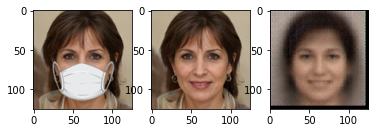

In [44]:
#Test a Model
model.eval()

images, images2 = dataiter.next()
#print_image(images[0], model = model2, correct_image = images2[0])
print_image(images[0], model = model, correct_image = images2[0], neptune_upload = True)

In [45]:
#Save the model as a artifact
def save_checkpoint(model, checkpoint_name):
    checkpoint_name_ext = checkpoint_name + ".pt"
    checkpoints = os.listdir("Checkpoints")
    path = os.path.join("Checkpoints", checkpoint_name_ext)
    try_number = 0
    while (os.path.exists(path)):
        try_number += 1
        checkpoint_name_ext = checkpoint_name + "_" + str(try_number) + ".pt"
        path = os.path.join("Checkpoints", checkpoint_name_ext)
    torch.save(model, path)
    neptune_checkpoint_path = 'model_checkpoints/' + checkpoint_name + "_" + str(try_number)
    run[neptune_checkpoint_path].upload(path)

In [46]:
save_checkpoint(model,"size_125_Large_model")

In [47]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.


All 2 operations synced, thanks for waiting!


Run FAC-21 received stop signal. Exiting


Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
